In [17]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
url='https://raw.githubusercontent.com/westonsfiala/ECEP595/master/lab3/adult_with_pii.csv'

adult = pd.read_csv(url)

## 1

In [18]:
def selina_query():
    # TODO: YOUR CODE HERE
    selinas_row = adult[adult['Name'] == 'Selina Barkworth']
    return selinas_row[selinas_row['Age'] == 30].shape[0]

In [19]:
assert selina_query() == 1

## 2

In [53]:
epsilon = 1.0
def dp_selina_query():
    sensitivity = 1
    selinas_row = adult[adult['Name'] == 'Selina Barkworth']
    return selinas_row[selinas_row['Age'] == 30].shape[0] + np.random.laplace(loc=0, scale= sensitivity/epsilon)
  

In [54]:
q2_runs = [dp_selina_query() for _ in range(100)]
noise_runs = [np.random.laplace(loc=1, scale=1/epsilon) for _ in range(100)]

assert stats.wasserstein_distance(q2_runs, noise_runs) < 1

## 3

The attacker tries to find out whether Selina is 30 or not. However, this is prevented by adding laplace noise to the result (which is 1). The sensitivity here is 1. since 1 is the smallest difference for two neighbouring tables if we use count queries. The original value can no longer be reconstructed due to the noise. And due to the mechanism described above, it is no longer possible to distinguish whether a certain value (in our case whether Selina is 30) is in the database or not. 

##  4

In [22]:
epsilon1 = 1.0
epsilon2 = 2.0
counting_query = lambda: 1

result_1 = counting_query() + np.random.laplace(loc=0, scale=1/epsilon1)
result_2 = counting_query() + np.random.laplace(loc=0, scale=1/epsilon2)
result_3 = counting_query() + np.random.laplace(loc=0, scale=1/epsilon1)

print(result_1, result_2, result_3)

1.537794097314211 0.49696320800424454 0.8352578711013197


In [44]:
def total_epsilon():
    return epsilon1 + epsilon1 + epsilon2

total_epsilonlon()

4.0

 We used the sequential composition property. Formally for two mechanisms, the first one eps1-DP second one eps2 DP, performing on the same data we can define a new mechanism which is (eps1 + eps2)-DP.

## 5

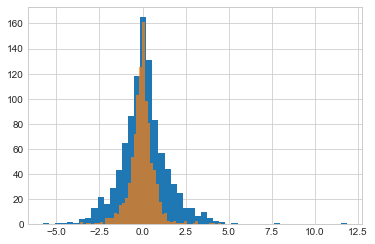

In [24]:
def empirical_dist_lap(scale):
    # YOUR CODE HERE
    return np.random.laplace(loc=0, scale=scale, size = 1000)
    #return [np.random.laplace(loc=0, scale=scale) for _ in range (1000)]
    

epsilon1 = 1.0
epsilon2 = 2.0

plt.hist(empirical_dist_lap(1/epsilon1), bins=50);
plt.hist(empirical_dist_lap(1/epsilon2), bins=50, alpha=.7);

Orange histogram is with epsilon2. And the blue histogramm is the on with epsilon1.
For the blue one the width is wider than the orange one. That means for eps1 we add more noise to the real value than for the case with epsilon2. Therefore the result manipulated with epsilon2 will be nearer to re real value than with eps1(blue) but this means also less privacy for epsilon1(orange) than epsilon2(blue).

## 6

In [25]:
def education_hist():
    # YOUR CODE HERE
    return adult.Education.value_counts()

education_hist()

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: Education, dtype: int64

In [49]:
# TEST CASE
h = education_hist()
assert h['HS-grad'] == 10501
assert h['12th'] == 433
assert h['Doctorate'] == 413

In [26]:
def dp_education_hist(epsilon):
    # YOUR CODE HERE
    #return adult.Education.value_counts() + np.random.laplace(loc=0, scale=1/epsilon)
    return education_hist().map(lambda x:x+np.random.laplace(loc=0, scale=1/epsilon))
    
dp_education_hist(0.1)

HS-grad         10499.693015
Some-college     7276.792514
Bachelors        5355.964939
Masters          1724.665648
Assoc-voc        1393.838598
11th             1183.479138
Assoc-acdm       1063.627596
10th              935.653833
7th-8th           649.433866
Prof-school       577.847415
9th               515.768587
12th              415.097685
Doctorate         413.618850
5th-6th           331.849350
1st-4th           165.111810
Preschool          42.954390
Name: Education, dtype: float64

In [27]:
# TEST CASE
h = dp_education_hist(1.0)
assert abs(h['HS-grad'] - 10501) < 100
assert abs(h['Doctorate'] - 413) < 100

Privacy cost is only epsilon since our data is split in k disjoints junks. And we use the mechanism on all these different disjoint junks. That means each row X is only in one chunk and the mechanism sees the data only once therefore we have a parallel composition. 


In [39]:
def dp_age_sum_clipping(epsilon, b):
    # TODO: YOUR CODE HERE
    #raise NotImplementedError()
    age = adult["Age"]
    age_clipped = np.clip(age, 0, b)
    return sum(age_clipped) + np.random.laplace(loc=0, scale=b/epsilon)

dp_age_sum_clipping(1.0, 100)

1256725.183845095

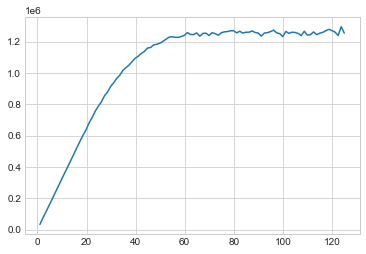

In [40]:
# TODO: Visualize noisy sums of ages
#x = [dp_age_sum_clipping(0.01, b) for b in range(125)]
#plt.plot(x)

bs=np.linspace(1,125, 100)
results = [dp_age_sum_clipping(0.01, b) for b in bs]
plt.plot(bs, results)

In [41]:
def dp_mean_age(epsilon, b):
    # TODO: YOUR CODE HERE
    noisy_age_sum = dp_age_sum_clipping(epsilon/2, b)
    noisy_count = len(adult) + np.random.laplace(0,epsilon/2)
    
    return noisy_age_sum / noisy_count

In [42]:
# TEST CASE for question 7
results = [dp_age_sum_clipping(1.0, 100) for _ in range(100)]
assert np.abs(np.mean(results) - adult['Age'].sum()) < 100
ages = [dp_mean_age(0.1, 100) for _ in range(100)]
assert np.abs(np.mean(ages) - adult['Age'].mean()) < 1